In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [210]:
def parse_nucleotides(sequence):
    new_seq = []
    map_to_vals = {"a": 1, "c": 2, "g": 3, "t":4}
    for symbol in sequence:
        new_seq.append(map_to_vals[symbol])
        
    return new_seq

In [35]:
def getskmer(snippet, profile):
    spaced_kmer = snippet * profile
    spaced_kmer = spaced_kmer[spaced_kmer != 0]
    s = ''.join(str(x) for x in spaced_kmer)
    return s

In [36]:
def maxcount(pos, seqs, seqs_kmers, spaced_kmer_profile, seq_to_investigate=0):
    target = seqs[seq_to_investigate]
    f = len(spaced_kmer_profile)
    counts_i = []
    indexes = []
    len_loop = min(f-1, pos)
    start = pos - len_loop
    end = pos+1
    for i in range(start, end):
        if spaced_kmer_profile[pos-i] != 1:
            counts_i.append(0)
            indexes.append(-1)
            continue
            
        # Extract k mers starting at selected position
        spaced_kmer = target[i : i+f] * spaced_kmer_profile
        spaced_kmer = spaced_kmer[spaced_kmer != 0]
        s = ''.join(str(x) for x in spaced_kmer)
        counts_i.append(seqs_kmers[s]) 
        indexes.append(i)
    
    return max(counts_i), indexes[np.argmax(counts_i)]

In [243]:
#
# CORRECT COUNTS - AN ATTEMPT AT FIXING THE ECLIPSE ERROR
#
def correct_counts(maxed_counts, mci, target_sequence, diff_profile, kmer_profile, starts, ends):
    f = len(kmer_profile)
    correction_artifact = []
    last_correction = 0 
    # When corrections are necessary they are written into the maxed_counts array
    for i in range(1,len(maxed_counts)):
        # Check for dip
        correction = 0
        
        if maxed_counts[i] < maxed_counts[i-1]: # This means that a read must've ended here
            if i >= f:
                s = getskmer(target_sequence[i-f:i], kmer_profile)
                if s in ends:
                    #print("In ends")
                    correction = ends[s]
                    #correction -= starts[s]
                    correction_artifact.append([correction, (i-f, i-1)])
                    s2 = getskmer(target_sequence[i-f+1:i+1], kmer_profile)
                    if s2 in starts:
                        correction -= starts[s2]
                    #print("-----------")
                    print("i:"+str(i))
                    for j in range(f):
                        sj = getskmer(target_sequence[i-f+j:i+j], kmer_profile)
                        if sj in starts:
                            print("start: val:"+str(starts[sj]) + " and j:"+str(j))
                        elif sj in ends:
                            print("end: val:"+str(ends[sj]) + " and j:"+str(j))
                    
                    #print("-----------")
                else:
                    print("Not in ends: "+str(i))
        elif maxed_counts[i] > maxed_counts[i-1]: # Read must've started here
            s = getskmer(target_sequence[i:i+f], kmer_profile)
            if s in starts:
                #print("In starts")
                correction = -starts[s]
                correction_artifact.append([correction, (i, i+f)])
                s2 = getskmer(target_sequence[i-1:i+f-1], kmer_profile)
                if s in ends:
                    print(j)
                    correction += ends[s2]
            else:
                print("Not in starts: " + str(i))
        '''
        if maxed_counts[i] != maxed_counts[i-1]:
            if i >= f:
                s = getskmer(target_sequence[i-f:i], kmer_profile)
                if s in ends:
                    #print("In ends")
                    correction = ends[s]
            s = getskmer(target_sequence[i:i+f], kmer_profile)
            if s in starts:
                #print("In starts")
                correction -= starts[s]
            correction_artifact.append([correction, i])
        '''
        
        '''
        if maxed_counts[i] < maxed_counts[i-1]: # This means that a read must've ended here
            if i >= f:
                s = getskmer(target_sequence[i-f:i], kmer_profile)
                if s in ends:
                    #print("In ends")
                    correction = ends[s]
                    correction_artifact.append([correction, (i-f, i-1)])
                else:
                    print("Not in ends: "+str(i))
        elif maxed_counts[i] > maxed_counts[i-1]: # Read must've started here
            s = getskmer(target_sequence[i:i+f], kmer_profile)
            if s in starts:
                #print("In starts")
                correction = -starts[s]
                correction_artifact.append([correction, (i, i+f)])
            else:
                print("Not in starts: " + str(i))
        '''
        #if correction != 0: print(correction)
        diff_profile[i-1] += correction
        #if correction != 0: correction_artifact.append([correction, (i-f, i-1)])

    return diff_profile, correction_artifact

In [244]:
def correct2(filename, str_profile, seq_to_investigate):
    seqs = []
    with open(filename) as file_in:
        for line in file_in:
            newline = line.rstrip('\n')
            sequence_chars = [char for char in newline]
            sequence = parse_nucleotides(sequence_chars)
            seqs.append(np.array(sequence))
    
    profile = [int(character) for character in str_profile]
    k = sum(profile)
    f = len(profile)
    
    # Turn into np arrays for componentwise multiplication
    profile = np.array(profile)
    
    # Count occurence of spaced k-mers
    seqs_kmers = {}
    starts = {}
    ends = {}
    for sequence in seqs:
        for i in range(len(sequence) - f):
            s = getskmer(sequence[i:i+f], profile)
            # For the count profiles
            if s not in seqs_kmers:
                seqs_kmers[s] = 1
            else:
                seqs_kmers[s] += 1
            # For collecting the start and end points
            if i == 0:
                if s not in starts:
                    starts[s] = 1
                else:
                    starts[s] += 1
            elif i == len(sequence)-f-1:
                if s not in ends:
                    ends[s] = 1
                else:
                    ends[s] += 1
    
    # Get maxcounts from counts
    target = seqs[seq_to_investigate]
    xpoints = np.array([i for i in range(len(target) - f)])
    max_counts = []
    max_count_indices = []
    for i in range(len(xpoints)):
        maxp, argmaxp = maxcount(i, seqs, seqs_kmers, profile, seq_to_investigate=seq_to_investigate)
        max_counts.append(maxp)
        max_count_indices.append(argmaxp)
    
    # Get diff profile:
    pre_corr_diff_profile = [max_counts[j] - max_counts[j-1] for j in range(1,len(max_counts))]
    
    # Apply correction strategy
    ypoints, correction_artifact = correct_counts(max_counts, max_count_indices, target, pre_corr_diff_profile.copy(), profile, starts, ends)
    
    return xpoints[1:], ypoints, max_counts, pre_corr_diff_profile, correction_artifact, max_count_indices

## Test

i:48
end: val:1 and j:0
i:106
end: val:1 and j:0
i:148
end: val:1 and j:0
[0, 1, -2, 0, 0, -1, -1, 1, 0, 0, 1, -1, -1, 1, 0, 3, 0, 1, 0, 0, -1, 0, 0, -1, 0, 1, 0, 1, 0, 1, -1, 0, 0, 0, 0, 0, -2, 2, 0, 0, 0, 0, 1, 1, -1, 0, -1, 2, 1, 0, 1, 0, -2, -1, 0, 0, -1, 0, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 2, 1, -2, -1, -1, -1, 0, 0, 1, -2, 1, 0, 0, 0, 0, -2, -1, 1, 3, 0, -1, 2, 1, 0, 0, 0, 1, 0, 1, -3, 1, 1, 0, 0, 0, 0, 1, 2, -1, 0, 1, 0, -2, 0, 0, -1, -2, 1, -1, -1, 0, -1, 0, 0, 0, 1, -1, 0, 0, 1, 1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 1, -2, 0, 0, 1, -1, 0, -1, 1, 0, 1, -3, 1, 0, 1, 0, -2, -1, 0, -1, 0, 0, 0, 0, 0, 0, 1, -1, -1, 0, 0, 0, -1, -1, 1, 1, 1, 0, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, -1, -2, 0, 2, 0, 1, 0, -1, 0, 0, 1, 0, 0, -1, -2, 0, 2, -1, 1, 0, 1, 1, 2]
[[1, (36, 47)], [1, (94, 105)], [1, (136, 147)]]
[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41

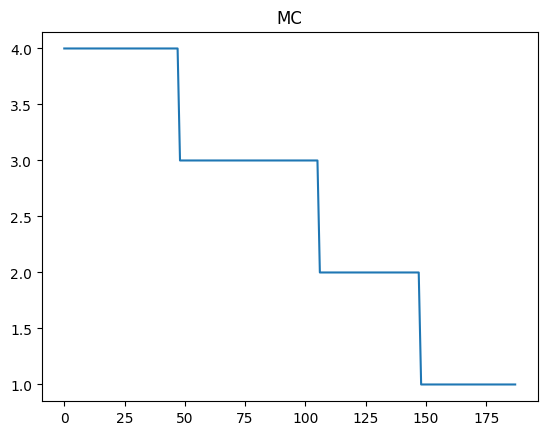

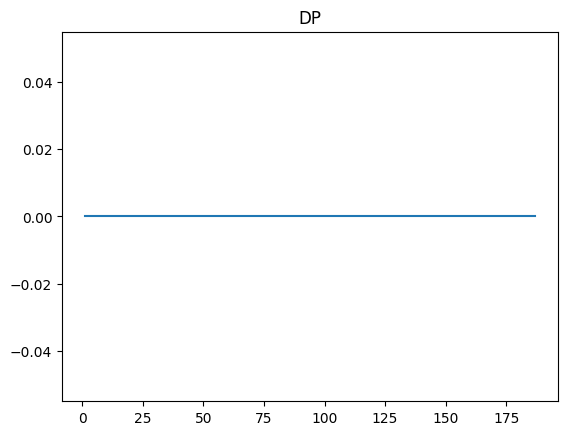

In [245]:
xpoints, ypoints, mc, diff_p, artifact, mci = correct2("data/simplest.txt", "111110101101", 3)
print(se)
print(artifact)
print(mci)
# Plot
plt.title("MC")
plt.plot([i for i in range(len(mc))], mc)
plt.show()
# Plot
plt.title("DP")
plt.plot(xpoints, ypoints)
plt.show()

## More Tests

i:121
end: val:1 and j:0
end: val:1 and j:8
start: val:1 and j:20
i:166
end: val:2 and j:0
end: val:1 and j:14
start: val:1 and j:20
start: val:1 and j:28
[[-1, (1, 34)], [-1, (65, 98)], [1, (88, 120)], [2, (133, 165)], [-1, (213, 246)]]


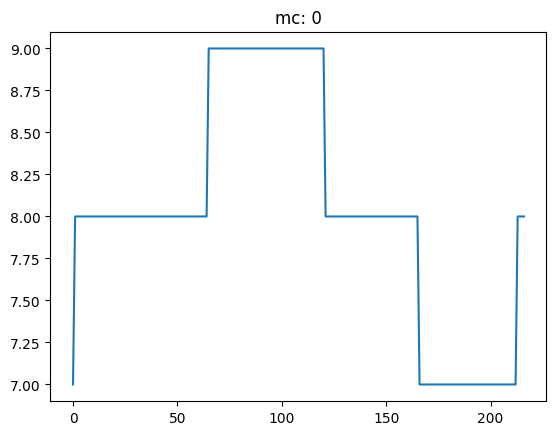

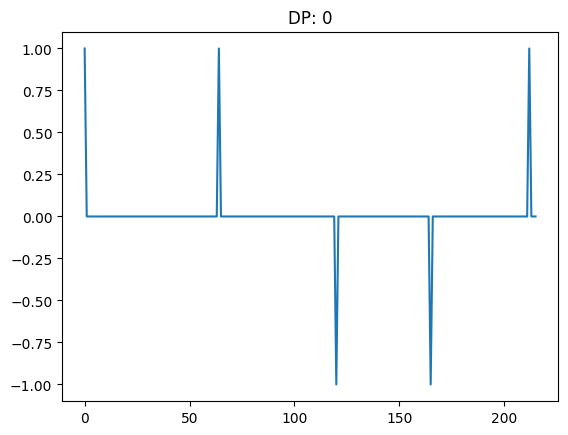

[0, 64, 120, 165, 212]


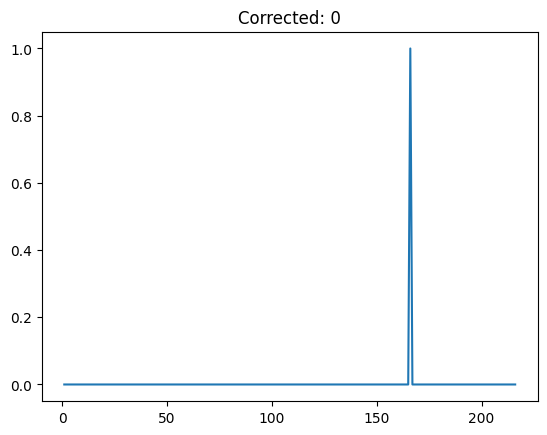

[165]


In [246]:
with open("data/output.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

for i in range(len(seqs)):
    # Execute the function we created above on the circular synthetic data.
    # 11110111111011011101010111011011111101111
    # 11111111111101011101010111011011111101111
    # 111111111111111111111111111111111
    # 111111111111101111111111111111111
    xpoints, ypoints, maxcounts, pc_diff_profile, artifact, mci = correct2("data/output.txt", "111111111111111111111111111111111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        print(artifact)
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        plt.show()
        print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        plt.show()
        print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        break